In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import (do_pca_pt, spearman_rho_pools, spearman_rho_grid, 
                                                   do_denoised_pca, calc_rhos, do_time_assign_by_pool)
from jtb_2022_code import FigureSingleCellData

from inferelator_prior.velocity.times import assign_times_from_pseudotime_sliding

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import spearmanr

In [3]:
## LOAD AND PROCESS UMAP FOR PCA AND PT PANELS ###
data = FigureSingleCellData()
data.do_projections()
data.apply_inplace_to_everything(do_pca_pt)
data.apply_inplace_to_expts(do_denoised_pca, max(N_PCS))
data.apply_inplace_to_expts(do_pca_pt, pca_key="denoised_pca", pt_key="denoised_pca_pt")
data.apply_inplace_to_expts(do_time_assign_by_pool)
data.load_pseudotime()

#data.save()

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


Text(0, 1, '# Cells')

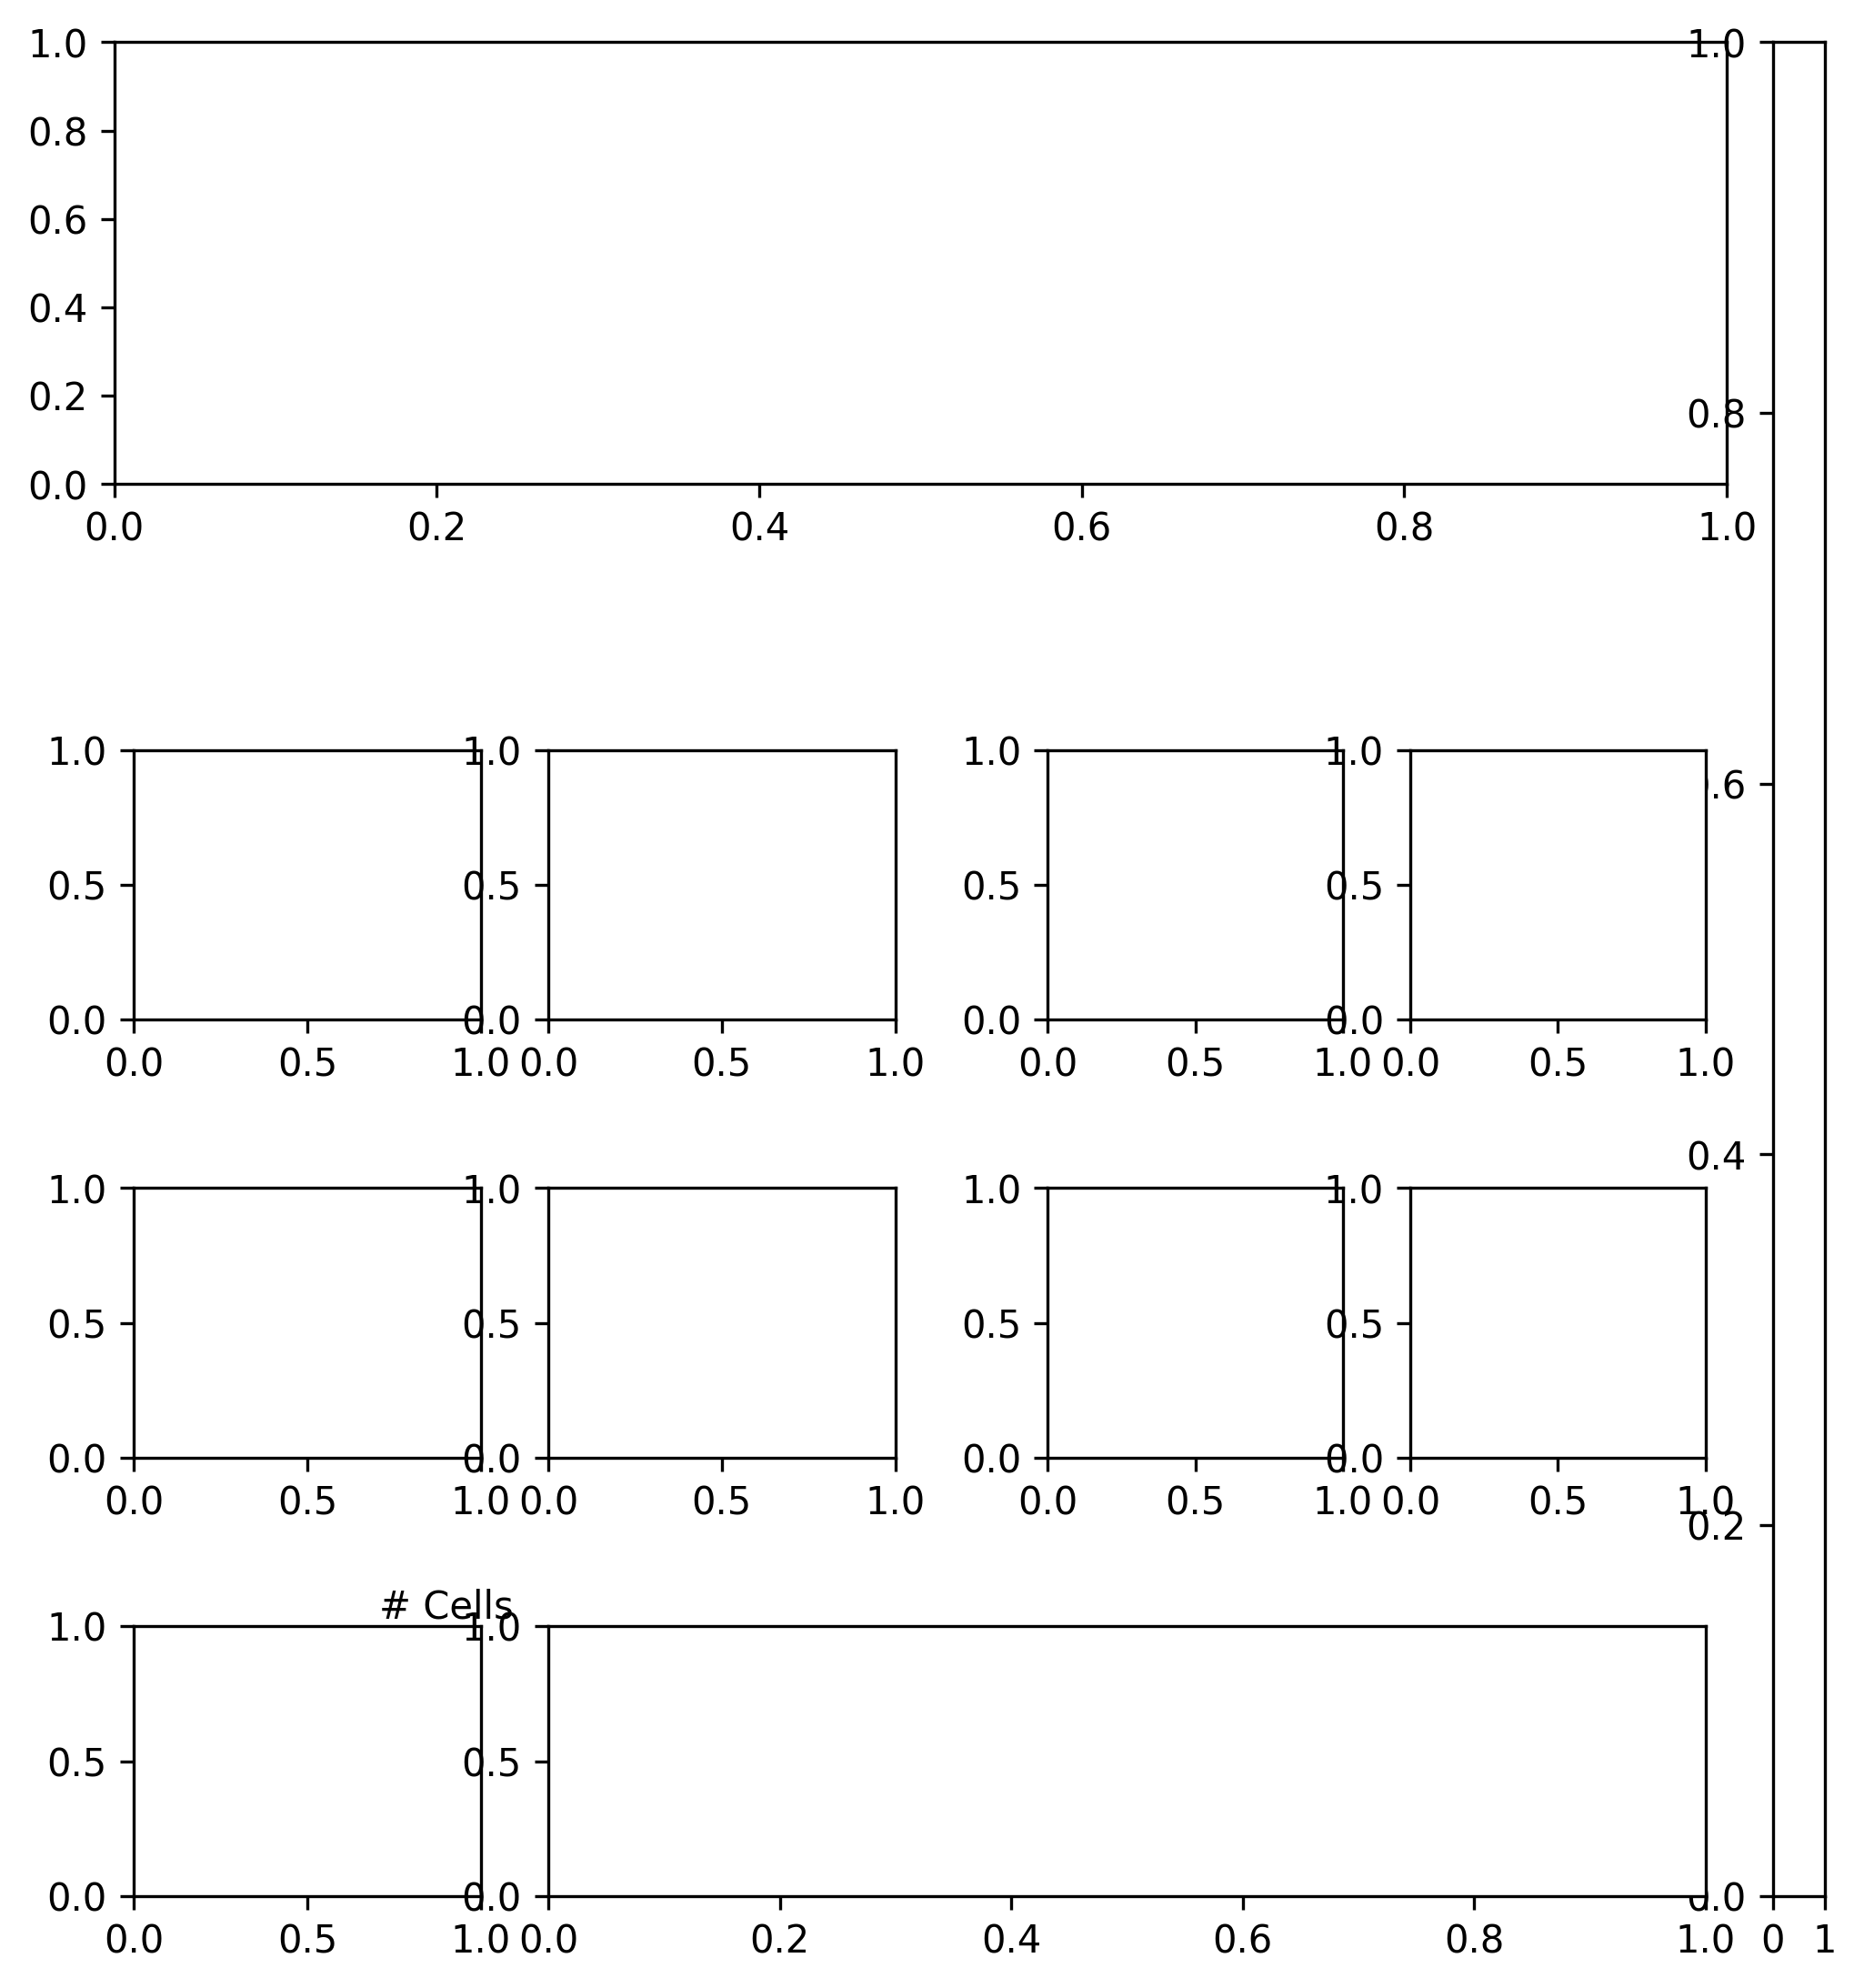

In [90]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

panel_labels = {'pca_1': "A",
                'pca_pt_1': "B",
                'pca_d1': "C",
                'pca_pt_d1': "D",
                'method_hm': "E",
                'time_hist': "F"}

panel_titles = {'pca_1': "Expt. 1",
                'pca_2': "Expt. 2",
                'pca_pt_1': "Expt. 1",
                'pca_pt_2': "Expt. 2",
                'pca_d1': "",
                'pca_d2': "",
                'pca_pt_d1': "",
                'pca_pt_d2': "",}

layout = [['schematic', 'schematic', 'schematic', 'schematic', 'schematic', 'pca_lgd'],
          ['pca_1', 'pca_2', '.', 'pca_pt_1', 'pca_pt_2', 'pca_lgd'],
          ['pca_d1', 'pca_d2', '.', 'pca_pt_d1', 'pca_pt_d2', 'pca_lgd'],
          ['method_hm', 'time_hist', 'time_hist', 'time_hist', 'time_hist', 'pca_lgd']]

hm_labels = {'pca': 'PCA', 'dpt': 'DPT', 
             'cellrank': 'CellRank', 
             'monocle': 'Monocle3', 
             'palantir': 'Palantir'}

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 1, 0.05, 0.85, 0.85, 0.15], 
                                               height_ratios=[2, 1, 1, 1],
                                               wspace=0.3, hspace=0.5), 
                              figsize=(8, 9), dpi=300)

axd['schematic'].set_position(Bbox([[0.116, 0.70], [0.855, 0.88]]))
axd['time_hist'].set_ylabel("# Cells", rotation=0, y=1, x=0)

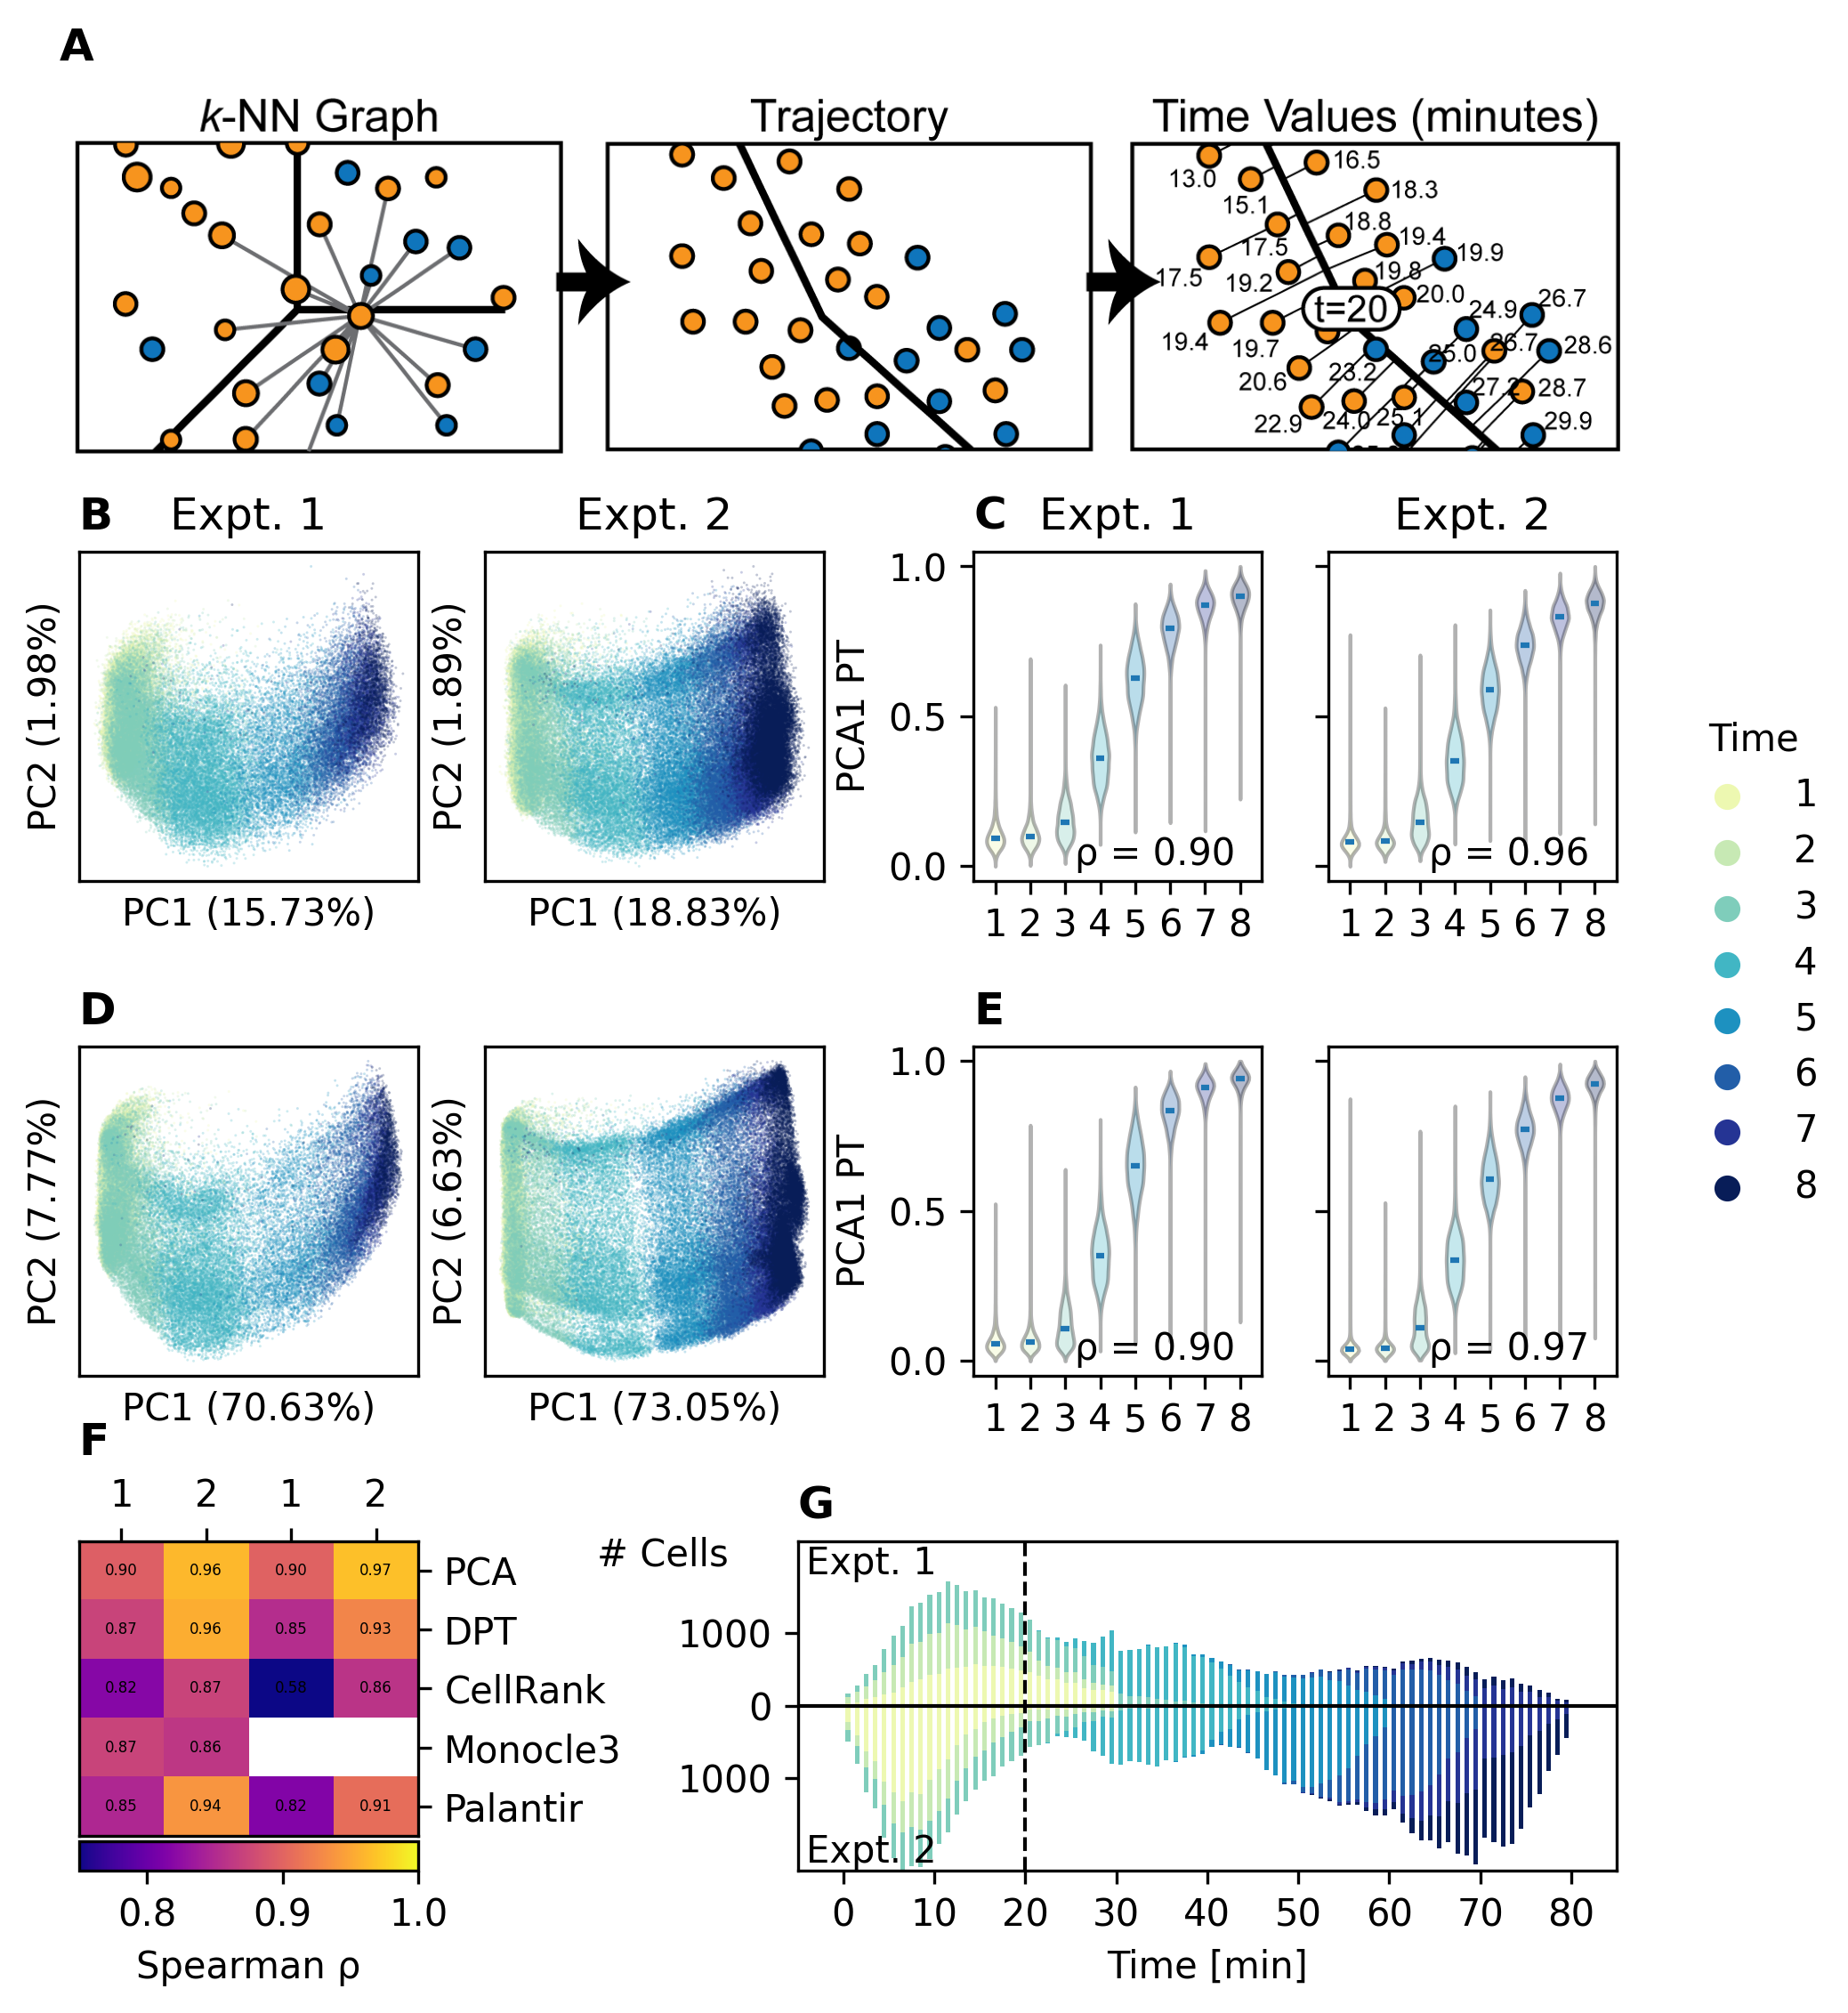

In [95]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.transforms import Bbox

panel_labels = {'schematic': "A",
                'pca_1': "B",
                'pca_pt_1': "C",
                'pca_d1': "D",
                'pca_pt_d1': "E",
                'method_hm': "F",
                'time_hist': "G"}

panel_titles = {'pca_1': "Expt. 1",
                'pca_2': "Expt. 2",
                'pca_pt_1': "Expt. 1",
                'pca_pt_2': "Expt. 2",
                'pca_d1': "",
                'pca_d2': "",
                'pca_pt_d1': "",
                'pca_pt_d2': "",}

layout = [['schematic', 'schematic', 'schematic', 'schematic', 'schematic', 'pca_lgd'],
          ['pca_1', 'pca_2', '.', 'pca_pt_1', 'pca_pt_2', 'pca_lgd'],
          ['pca_d1', 'pca_d2', '.', 'pca_pt_d1', 'pca_pt_d2', 'pca_lgd'],
          ['method_hm', 'time_hist', 'time_hist', 'time_hist', 'time_hist', 'pca_lgd']]

hm_labels = {'pca': 'PCA', 'dpt': 'DPT', 
             'cellrank': 'CellRank', 
             'monocle': 'Monocle3', 
             'palantir': 'Palantir'}

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 1, 0.05, 0.85, 0.85, 0.15], 
                                               height_ratios=[1, 1, 1, 1],
                                               wspace=0.3, hspace=0.5), 
                              figsize=(8, 9), dpi=300)

axd["pca_lgd"].axis('off')

axd['schematic'].set_position(Bbox([[0.116, 0.70], [0.855, 0.88]]))
axd['schematic'].imshow(plt.imread(FIG2A_FILE_NAME), aspect='equal')
axd['schematic'].axis('off')

def _minmax_time(adata, key='time_pca_pt'):
    return adata.obs[key].min(), adata.obs[key].max()

minmax = np.array(data.apply_to_expts(_minmax_time))
min_time = int(np.floor(min(minmax[:, 0])))
max_time = int(np.ceil(max(minmax[:, 1])))


def _get_time_hist(adata, min_time, max_time, key='time_pca_pt'):
    cuts = np.arange(min_time, max_time + 1)
    return [np.bincount(pd.cut(adata.obs.loc[adata.obs['Pool'] == x, key], 
                               cuts, labels=np.arange(len(cuts) - 1)).dropna(),
                        minlength=len(cuts) - 1) for x in range(1, 9)]


def _make_method_heatmap_data(pdata):
    raw = pdata.all_data.uns['rho'].loc[(slice(None), "WT"), :].T
    raw.columns = pd.MultiIndex.from_tuples([(1, "raw"), (2, "raw")])
    
    denoised = pdata.all_data.uns['denoised_rho'].loc[(slice(None), "WT"), :].T.reindex(raw.index)
    denoised.columns = pd.MultiIndex.from_tuples([(1, "denoised"), (2, "denoised")])
    
    return pd.concat((raw, denoised), axis=1)


def _plt_pt_violins(pdata, ax, pt_key, include_labels=True):
    pca_pt_data = {k: v[pt_key] for k, v in pdata.obs[[pt_key, 'Pool']].groupby("Pool")}
    ref = ax.violinplot([pca_pt_data[j] for j in range(1,9)], showmeans=False, showmedians=True, showextrema=False)
    ax.set_xticks(np.arange(8) + 1, labels=np.arange(8) + 1)
    ax.set_yticks([0.0, 0.5, 1.0], labels=[0.0, 0.5, 1.0] if include_labels else ['', '', ''])
    
    if include_labels:
        ax.set_ylabel("PCA1 PT")
    
    rho = spearman_rho_pools(pdata.obs['Pool'], pdata.obs[pt_key])
    ax.annotate("ρ = " + f"{rho:.2f}", xy=(5, 0.2),  xycoords='data', xytext=(0.35, 0.05), textcoords='axes fraction')
    
    for part, c in zip(ref['bodies'], pool_palette()):
        part.set_facecolor(c)
        part.set_edgecolor('black')
        
    return ref

def plt_time_histogram(data_obj, ax, tmin, tmax, key='time_pca_pt'):
    
    hist_limit, fref = [], []
    hist_labels = np.linspace(tmin + 0.5, tmax - 0.5, tmax - tmin)
 
    for i in range(1, 3):
            
        bottom_line = None
        for j, hist_data in enumerate(_get_time_hist(data_obj.expt_data[(i, "WT")], tmin, tmax, key=key)):
            
            bottom_line = np.zeros_like(hist_data) if bottom_line is None else bottom_line
            
            # Flip across the X axis for the second expt
            if i == 2:
                hist_data *= -1
                
            fref.append(ax.bar(hist_labels, 
                               hist_data, 
                               bottom=bottom_line, 
                               width=0.5, 
                               label=i, color=pool_palette()[j]))
                        
            bottom_line = bottom_line + hist_data
            
            hist_limit.append(np.max(np.abs(bottom_line)))

    hist_limit = max(hist_limit)
    ax.set_xticks(np.arange(9) * 10)
    ax.set_yticks([-1000, 0, 1000], labels=[1000, 0, 1000])
    ax.set_ylim(-1 * hist_limit, hist_limit)
    ax.set_ylabel("# Cells", rotation=0, y=0.9, x=0)
    ax.set_xlabel("Time [min]")
    ax.annotate("Expt. 1", xy=(80, 500),  xycoords='data', xytext=(0.01, 0.9), textcoords='axes fraction')
    ax.annotate("Expt. 2", xy=(80, -500),  xycoords='data', xytext=(0.01, 0.025), textcoords='axes fraction')
    ax.axhline(0, 0, 1, linestyle='-', linewidth=1.0, c='black')
    ax.axvline(20, 0, 1, linestyle='--', linewidth=1.0, c='black')
    ax.set_xlim(-5, 85)
                        
    return fref


for i in range(1,3):
    pca_key = "pca_" + str(i)
    pca_d_key = "pca_d" + str(i)
    
    pt_key = "pca_pt_" + str(i)
    pt_d_key = "pca_pt_d" + str(i)
    
    pca_data = data.expt_data[i, "WT"]
    pca_d_data = get_clean_anndata(pca_data)
    pca_d_data.obsm['X_pca'] = pca_data.obsm['denoised_pca'].copy()
    pca_d_data.uns['pca'] = pca_data.uns['denoised_pca'].copy()
    

    ### PANEL A/C ###
    fig_refs[pca_key] = sc.pl.pca(pca_data, ax=axd[pca_key], 
                                  color="Pool", palette=pool_palette(), 
                                  show=False, alpha=0.25, size=2, legend_loc='none',
                                  annotate_var_explained=True)
    fig_refs[pca_d_key] = sc.pl.pca(pca_d_data, ax=axd[pca_d_key], 
                                    color="Pool", palette=pool_palette(),
                                    show=False, alpha=0.25, size=2, legend_loc='none',
                                    annotate_var_explained=True)

    ### PANEL B/D ###
    fig_refs[pt_key] = _plt_pt_violins(pca_data, axd[pt_key], 'pca_pt', include_labels= i == 1)
    fig_refs[pt_d_key] = _plt_pt_violins(pca_d_data, axd[pt_d_key], 'denoised_pca_pt', include_labels= i == 1)


fig_refs['hist_divider'] = make_axes_locatable(axd['time_hist'])
fig_refs['hist_leftpad'] = fig_refs['hist_divider'].append_axes('left', size='35%', pad=0.1)
fig_refs['hist_leftpad'].axis('off')
fig_refs['time_hist'] = plt_time_histogram(data, axd['time_hist'], 0, 80, key='time_pca_pt')

hm_data = _make_method_heatmap_data(data)

fig_refs['method_hm'] = axd['method_hm'].imshow(hm_data, vmin=0.75, vmax=1.0,
                                                cmap='plasma', aspect='auto', interpolation='nearest')

axd['method_hm'].set_yticks(range(hm_data.shape[0]), labels=hm_data.index.map(lambda x: hm_labels[x]))
axd['method_hm'].set_xticks(range(hm_data.shape[1]), labels=[1, 2, 1, 2])
axd['method_hm'].xaxis.tick_top()
axd['method_hm'].yaxis.tick_right()

divider = make_axes_locatable(axd['method_hm'])
axd['method_hm_cbar'] = divider.append_axes('bottom', size='10%', pad=0.02)
fig_refs['method_hm_cbar'] = fig.colorbar(fig_refs['method_hm'], cax=axd['method_hm_cbar'], orientation="horizontal", aspect=80)
fig_refs['method_hm_cbar'].set_label("Spearman ρ")

# https://stackoverflow.com/questions/11917547/how-to-annotate-heatmap-with-text-in-matplotlib
for y in range(hm_data.shape[0]):
    for x in range(hm_data.shape[1]):
        n = hm_data.iloc[y, x]
        if np.isnan(n):
            continue
        axd['method_hm'].text(x, y, '%.2f' % n, 
                              horizontalalignment='center', 
                              verticalalignment='center', 
                              size=4)
        
np.arange(max_time - min_time - 1)

fig_refs['pca_legend'] = add_legend(axd['pca_lgd'], 
                                    pool_palette(), 
                                    data.all_data.obs['Pool'].dtype.categories.values,
                                    title = "Time")

for ax_id, label in panel_labels.items():
    axd[ax_id].set_title(label, loc='left', weight='bold')
    
for ax_id, label in panel_titles.items():
    axd[ax_id].set_title(label)

fig.savefig(FIGURE_2_FILE_NAME + ".png", facecolor="white") 

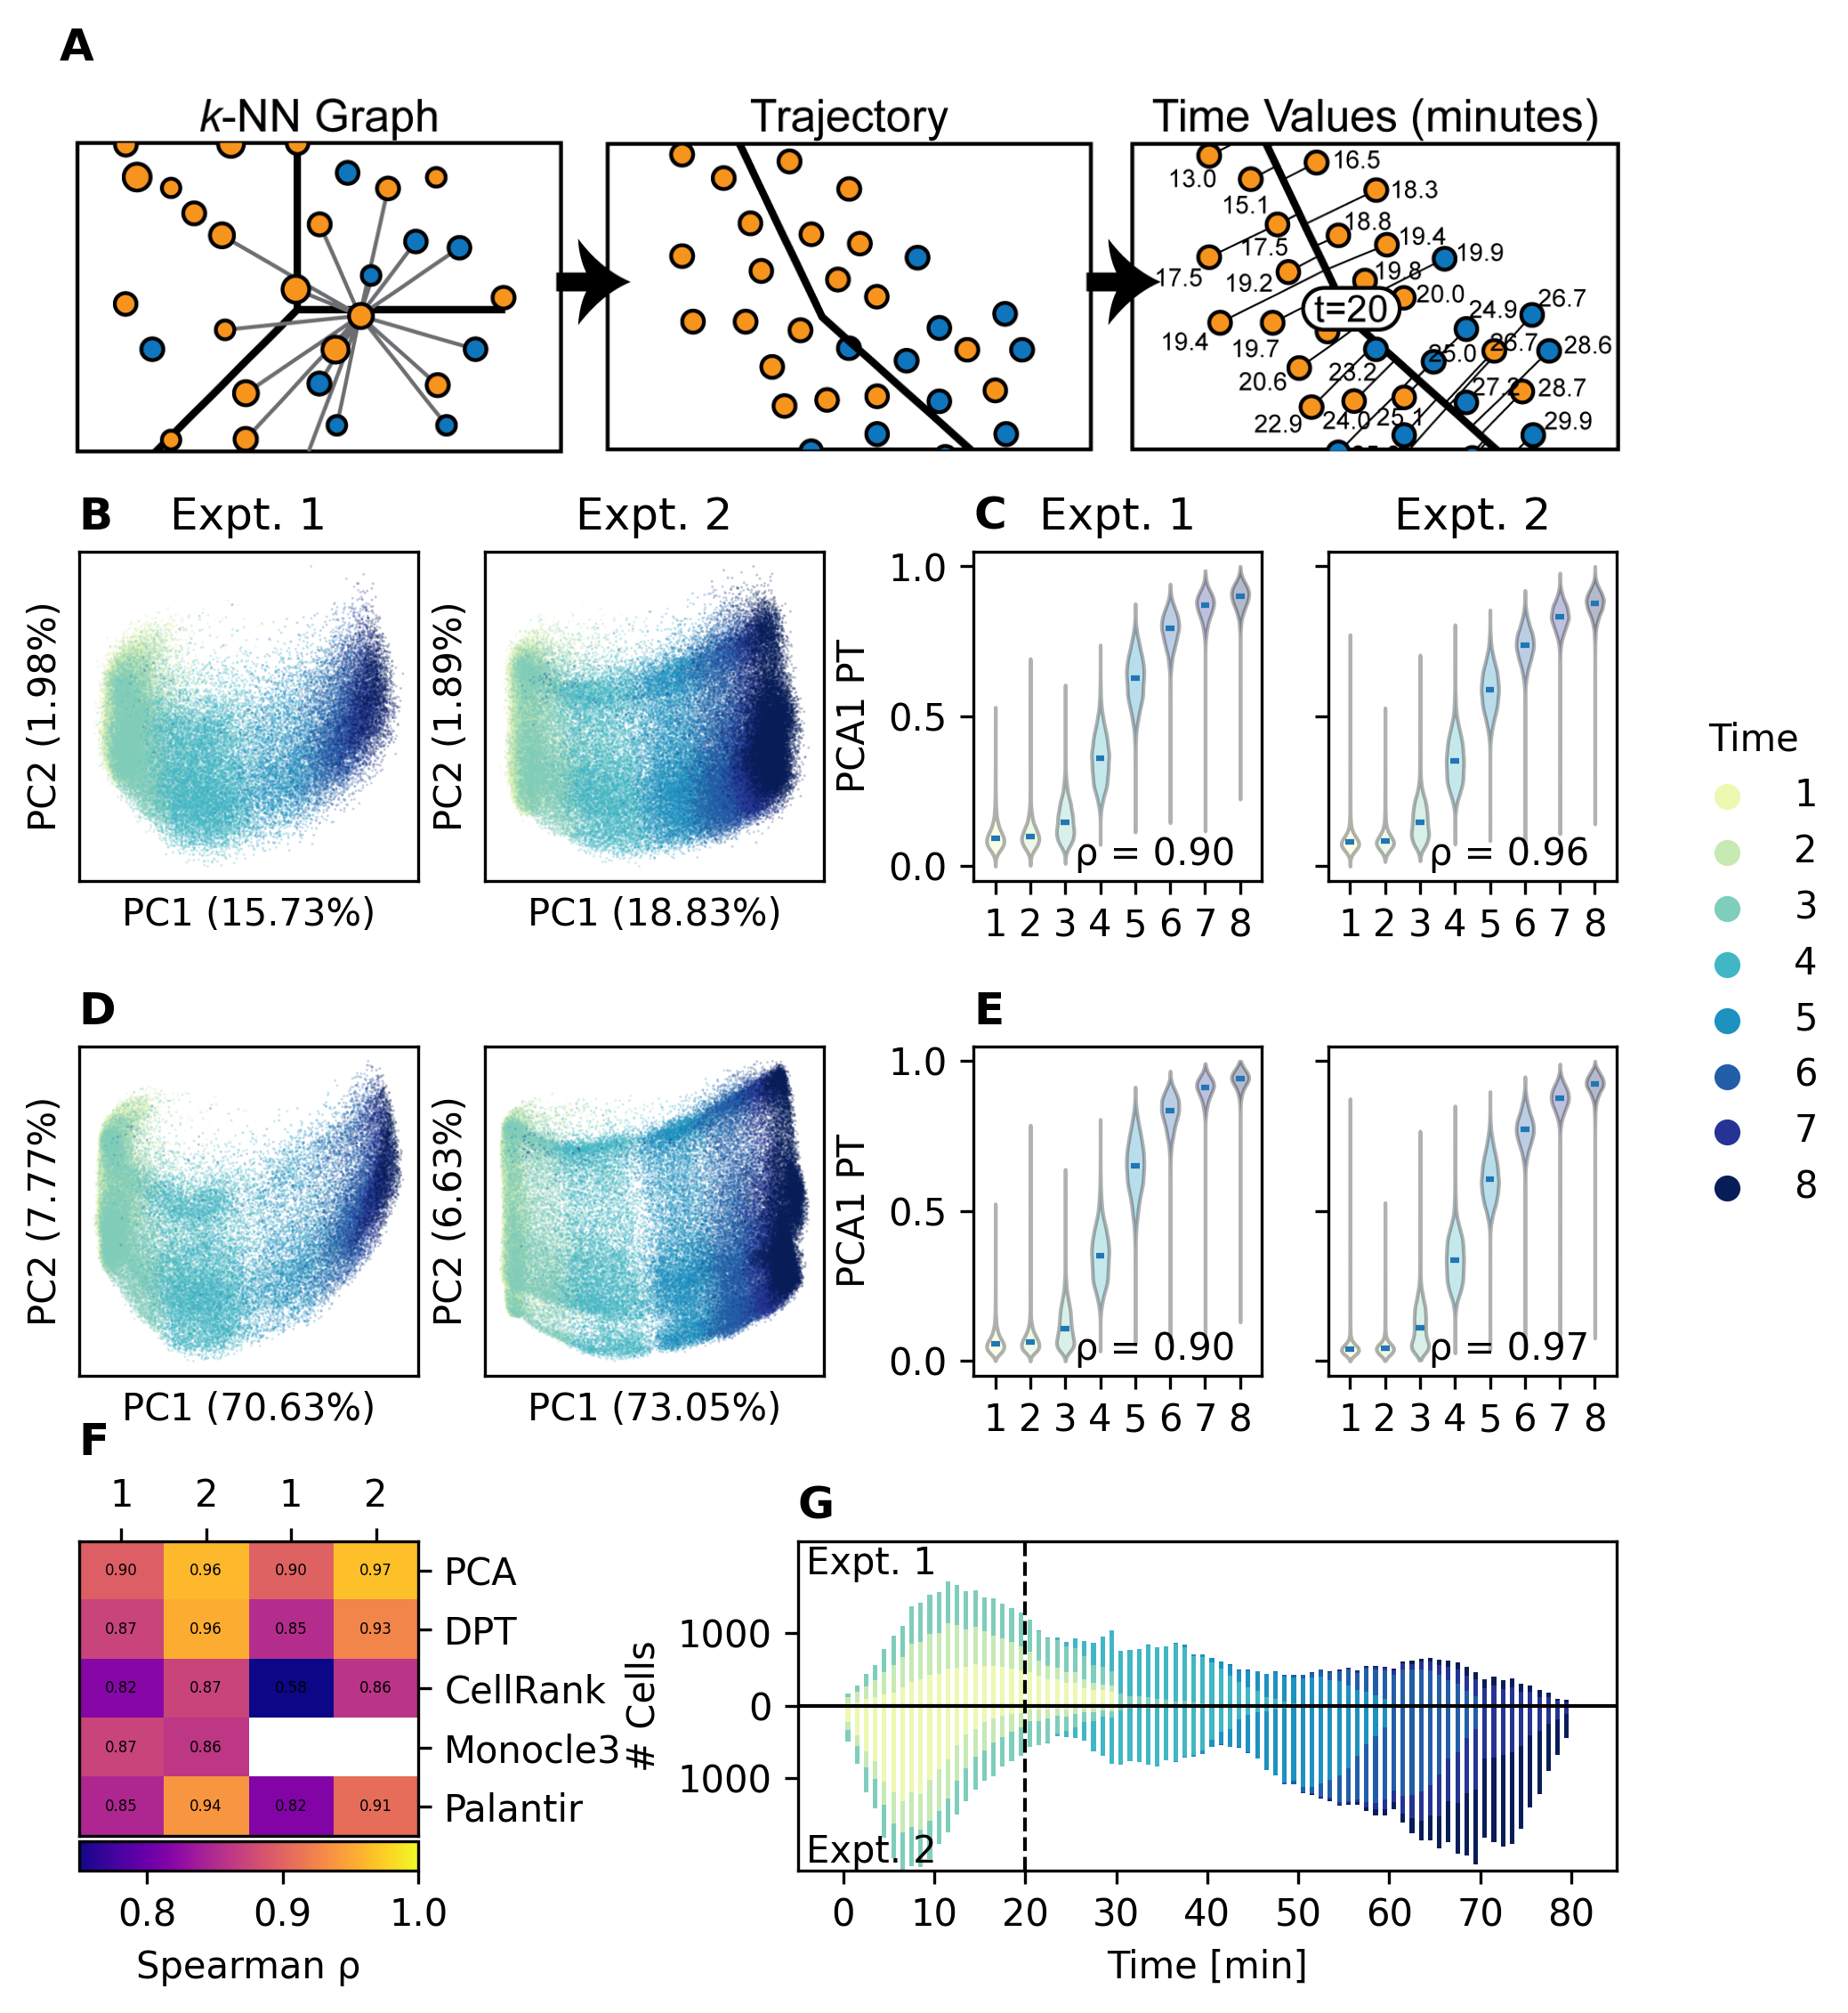

In [68]:
axd['schematic'].set_position(Bbox([[0.116, 0.70], [0.855, 0.88]]))
fig

In [73]:
Bbox

matplotlib.transforms.Bbox